In [292]:
import numpy as np
import freegs
from freegs.plotting import plotConstraints
from freegs.critical import find_critical
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import sys
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display, clear_output
import time

In [ ]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [300]:
# Create the machine, which specifies coil locations
# and equilibrium, specifying the domain to solve over
# this has to be either
# freegs.machine.MASTU(), in which case:
#tokamak = freegs.machine.MASTU()
# or
# MASTU_coils.MASTU_wpass()
from freegsnke import MASTU_coils
tokamak = MASTU_coils.MASTU_wpass()


# Creates equilibrium object and initializes it with 
# a "good" solution
plasma_psi = np.loadtxt('plasma_psi_example.txt')
eq = freegs.Equilibrium(tokamak=tokamak,
                        #domains can be changed in principle, 
                        #in practice domains as below are used to detect
                        #plasma hitting the wall during evolution
                        Rmin=0.1, Rmax=2.0,    # Radial domain
                        Zmin=-2.2, Zmax=2.2,   # Height range
                        #grid resolution can be changed
                        nx=129, ny=129, # Number of grid points
                        psi=plasma_psi)     

# Sets desired plasma properties for the 'starting equilibrium'
# values can be changed
profiles = freegs.jtor.ConstrainPaxisIp(4e3, # Plasma pressure on axis [Pascals]
                                        8e5, # Plasma current [Amps]
                                        0.5, # vacuum f = R*Bt
                                        alpha_m = 1.0,
                                        alpha_n = 2.0)


# Sets some shape constraints (here very close to those used for initialization)
Rx = 0.7
Zx = 1.0

Rmid = 1.4   # Outboard midplane
Rin = 0.4  # Inboard midplane

xpoints = [(Rx, -Zx),   # (R,Z) locations of X-points
           (Rx,  Zx)]
isoflux = [
    #if geometry is changed considerably, it can be useful to  
    #start by imposing this first set of constraints only
           (Rx,Zx, Rx,-Zx),
           (Rmid, 0, Rin, 0.0),
           (Rmid,0, Rx,Zx),
    
           
    #then adding all of the following
           (Rx,-Zx, 1, -0.9),
           (Rx,-Zx, Rmid, -0.4),   # Outboard midplane, lower X-point
           (Rx,Zx, Rmid, +0.4),   # Outboard midplane, upper X-point
           (Rx,Zx, 1, +0.9),
           
           

           # Link inner and outer midplane locations
           (Rx, Zx, .5, 1.25),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx, -Zx, .5, -1.25),

#       # Separatrix in the divertor chamber
           (Rx,-Zx, 0.6, -1.45),
           (Rx, Zx, 0.6,  1.45),
           
           (Rx,-Zx, 0.68, -1.55),
           (Rx, Zx, 0.68,  1.55),
           
           (Rx,-Zx, 0.8, -1.7),
           (Rx, Zx, 0.8,  1.7),
           
           (Rx,-Zx, 0.9, -1.75),
           (Rx, Zx, 0.9,  1.75),
           
            (Rx,-Zx, 1., -1.8),
            (Rx, Zx, 1.,  1.8),
           
            (Rx,-Zx, 1.1, -1.9),
            (Rx, Zx, 1.1,  1.9),

            (Rx,-Zx, 1.2, -1.9),
            (Rx, Zx, 1.2,  1.9),

            (Rx,-Zx, 1.3, -2),
            (Rx, Zx, 1.3,  2),

       

           (Rx,-Zx, 2, -1.85),
           (Rx, Zx, 2,  1.85),

         #   (Rx,-Zx, 1.5, -1.85),
         #   (Rx, Zx, 1.5,  1.85),

         #   (Rx,-Zx, 1.6, -1.85),
         #   (Rx, Zx, 1.6,  1.85),

         #   (Rx,-Zx, 1.7, -1.85),
         #   (Rx, Zx, 1.7,  1.85),

         #   (Rx,-Zx, 1.8, -1.85),
         #   (Rx, Zx, 1.8,  1.85),

          
           
           
        # infra-coils separatrix
           (Rx,-Zx, .35, -1.3),
           (Rx, Zx, .35,  1.3),
           
       #     (Rx,-Zx, .5, -1.8),
       #     (Rx, Zx, .5,  1.8),
           
       #     (Rx,-Zx, .6, -1.9),
       #     (Rx, Zx, .6,  1.9),
    
        #    (Rx,-Zx, .7, -2.2),
        #    (Rx, Zx, .7,  2.2),
           ]

constrain = freegs.control.constrain(xpoints=xpoints, 
                                     gamma=5e-6, 
                                     isoflux=isoflux
                                    )
constrain(eq)

In [301]:
eq.tokamak['Solenoid'].current = -5000.0000

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

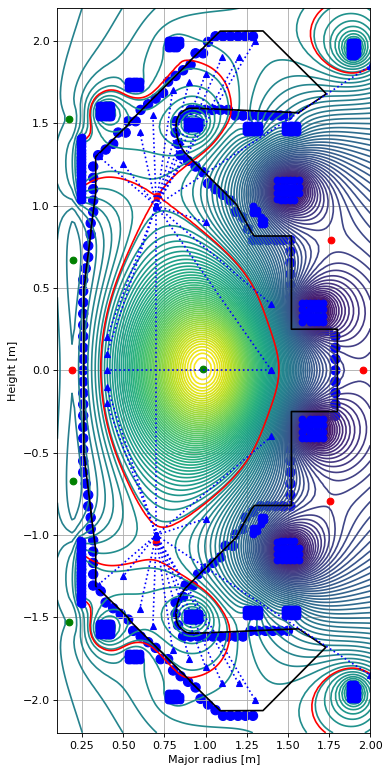

In [302]:
# Nonlinear solve
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=1e-2)   
fig = plt.figure(figsize=(6, 12), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);
constrain.plot(axis=ax,show=False)

In [303]:
# Initialize the evolution object
# This uses the starting equilibrium to get all the geometric constraints/grids etc
from freegsnke import evolve_plasma_NK
stepping = evolve_plasma_NK(profiles, eq)

# In absence of a policy, this calculates the active voltages U_active
# to maintain the currents needed for the equilibrium statically
U_active = np.matmul(stepping.evol_currents.R_matrix, stepping.currents_vec)[:MASTU_coils.N_active]

In [275]:
def get_O_points(eq):
    return find_critical(eq.R, eq.Z, eq.psi())[0][0]

def calculate_width(eq):
    inout = eq.innerOuterSeparatrix()
    return inout[1] - inout[0]

In [276]:
# Example of evolution with constant applied voltages
t = 0
flag = 0
history_times = [t]
t_per_step = []

#use the following to reset stepping.eq1 to a new IC
stepping.NK.solve(eq, profiles)
stepping.set_currents_eq1(eq)

history_currents = [stepping.currents_vec]
history_o_points = [get_O_points(stepping.eq1)]
history_equilibria = [deepcopy(stepping.eq1)]
history_width = [calculate_width(stepping.eq1)]
history_elongation = [stepping.eq1.geometricElongation()]

counter = 0
max_count = 30
this_is_first_step = 1

rel_change_0 0.008935156474097606
0.006502405408312463 coeffs= [-0.66348867  0.0437659   0.11075569 -0.06276977]
0.000807982208306078 coeffs= [-0.06719373  0.38513068  0.05063004 -0.1184483   0.0273397 ]
8.165471514748876e-05 coeffs= [-0.11226577 -0.10088204  0.09223203 -0.10368277  0.03999112]
3.916903597806447e-06 coeffs= [-0.54597857  1.37481198 -0.14110295  0.02162964]
2.480755942317061e-07 coeffs= [ 1.21685872 -0.54088053  0.5497779  -0.4611434   0.03927562]


In [50]:
stepping.set_currents_eq1(eq)
results = stepping.qfe.quants_out(stepping.eq1, stepping.profiles1)
stepping.dR = 0

In [51]:
abs_currents = abs(stepping.currents_vec)
stepping.vals_for_rel_change = np.where(abs_currents>stepping.threshold, abs_currents, stepping.threshold)


In [492]:
results = stepping.results1.copy()

In [56]:
stepping.do_LIdot(U_active, 
                          stepping.currents_vec, 
                          .00125,
                          results,
                          stepping.dR)

find_dt_evolve dt =  8.77914951989026e-05


In [57]:
stepping.eq2.plasma_psi = stepping.eq1.plasma_psi.copy()
Fresidual = stepping.Fcircuit(U_active, stepping.trial_currents, 1e-7, False)
rel_change = abs(Fresidual)/stepping.vals_for_rel_change
max(rel_change)

0.0007837368462963344

In [465]:
stepping.dR = stepping.update_R_matrix(stepping.trial_currents)

In [156]:
stepping.eq2.plasma_psi = stepping.eq1.plasma_psi.copy()

In [159]:
max(rel_change1)

2.8239060889667656e-09

In [160]:
used_n

4

In [161]:
stepping.coeffs

array([-2.08869118, -1.42661417, -1.31696038, -1.15837183])

In [153]:
stepping.currents_vec = stepping.trial_currents.copy()
stepping.eq1.plasma_psi = stepping.eq2.plasma_psi.copy()

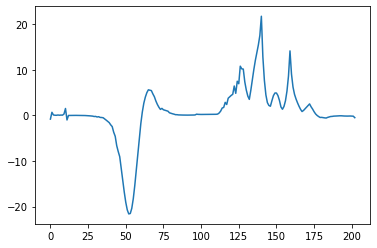

In [101]:
plt.plot(stepping.Q[:,1])

In [278]:
this_is_first_step = 0

In [287]:
flag = stepping.do_step(U_active, 
                        this_is_first_step=this_is_first_step,
                        eq=eq,
                        initial_rel_change=.002,
                        verbose_currents=True,
                        rtol_currents=3e-4,
                        n_k=5,
                        max_iter=10,
                        conv_crit=.1,
                        grad_eps=.0005,
                        verbose_NK=False
                        )

find_dt_evolve dt =  0.0013333333333333333
final timestep =  0.0013333333333333333
initial max_rel_change =  0.0005225512930640406 11 4.819760482070357e-05
dcurrent =  [-5.04165304e-01  2.30905527e-01  1.66276120e-02 -4.99895360e-03
  8.95844568e-05 -4.36659034e-02 -3.27642323e-03 -2.81659288e-02
 -1.12652354e-02 -8.57119783e-02 -2.11058284e-01  1.58998437e+00
  9.24268698e-02  7.28184501e-02  6.17856134e-02  5.46303385e-02
  4.99695103e-02  4.82640262e-02  5.15150938e-02  6.18975583e-02
  5.99476381e-02  7.83887537e-02  8.97994215e-02  1.07927809e-01
  1.35512281e-01  2.00283920e-01  2.52343282e-01  3.21182563e-01
  4.01274422e-01  6.14982892e-01  5.57377140e-01  8.91782495e-01
  8.01364980e-01  1.17738821e+00  1.24122399e+00  1.30150379e+00
  1.57670174e+00  2.03379725e+00  2.60326701e+00  3.30217955e+00
  4.11863153e+00  4.63954034e+00  5.46524893e+00  5.80812286e+00
  6.50360573e+00  6.49924232e+00  6.19756161e+00  6.04666619e+00
  5.45953462e+00  4.37811575e+00  2.77635260e+00  6.

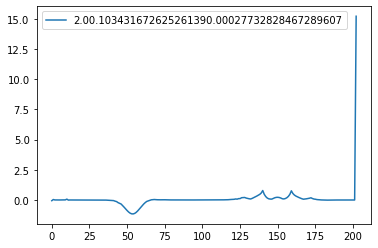

In [138]:
i=10
plt.plot(stepping.arnoldi_trials[i,:-3], label=str(stepping.arnoldi_trials[i,-3])+str(stepping.arnoldi_trials[i,-2])+str(stepping.arnoldi_trials[i,-1]))
plt.legend()

In [135]:
stepping.arnoldi_trials[:,-3:]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.14915821e-02, 1.20746751e-04],
       [1.00000000e+00, 2.40970536e-01, 1.43235600e-03],
       [1.00000000e+00, 7.88935136e-01, 0.00000000e+00],
       [2.00000000e+00, 7.77128623e-01, 0.00000000e+00],
       [3.00000000e+00, 2.11527807e-02, 9.69134270e-04],
       [1.00000000e+00, 1.83746899e-01, 0.00000000e+00],
       [2.00000000e+00, 7.87207705e-03, 1.18995582e-04],
       [1.00000000e+00, 2.25706014e-01, 3.62377424e-04],
       [1.00000000e+00, 9.95240664e-01, 0.00000000e+00],
       [2.00000000e+00, 1.03431673e-01, 2.77328285e-04]])

In [12]:
abs_currents = abs(stepping.currents_vec)
stepping.vals_for_rel_change = np.where(abs_currents>stepping.threshold, abs_currents, stepping.threshold)

In [14]:
stepping.do_LIdot(U_active, 
                stepping.currents_vec, 
                .001,
                results,
                stepping.dR)

In [18]:
stepping.eq2.plasma_psi = stepping.eq1.plasma_psi.copy()


In [30]:
di = stepping.dI(Fresidual, clip=100)
stepping.trial_currents += di

In [33]:
rel_change = abs(Fresidual)/stepping.vals_for_rel_change
max(rel_change)

4.46895296895522e-06

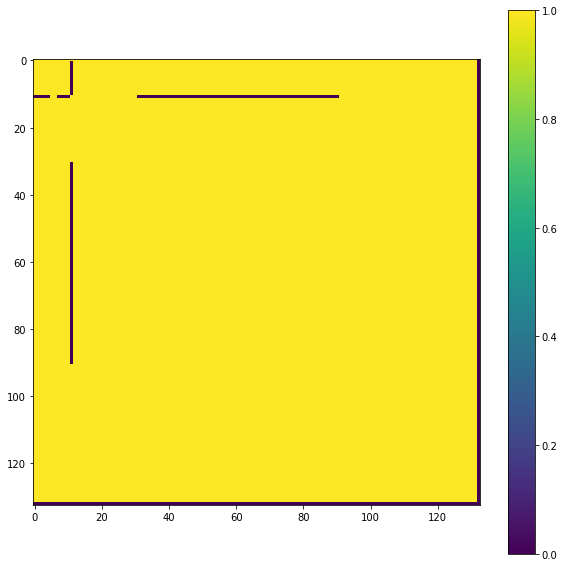

In [83]:
plt.figure(figsize=(10,10))
plt.imshow(stepping.evol_currents.L0_matrix>0)
plt.colorbar()

In [304]:
# Example of evolution with constant applied voltages
t = 0
flag = 0
history_times = [t]
t_per_step = []

#use the following to reset stepping.eq1 to a new IC
stepping.NK.solve(eq, profiles)
stepping.set_currents_eq1(eq)

history_currents = [stepping.currents_vec]
history_o_points = [get_O_points(stepping.eq1)]
history_equilibria = [deepcopy(stepping.eq1)]
history_width = [calculate_width(stepping.eq1)]
history_elongation = [stepping.eq1.geometricElongation()]

counter = 0
max_count = 10
this_is_first_step = 1
while flag<1 and counter<max_count:
    clear_output(wait=True)
    display(f'Step: {counter}/{max_count-1}')
    
    t_start = time.time()
    flag = stepping.do_step(U_active, 
                        this_is_first_step=this_is_first_step,
                        eq=eq,
                        initial_rel_change=.002,
                        verbose_currents=True,
                        rtol_currents=3e-4,
                        n_k=6,
                        max_iter=20,
                        conv_crit=.35,
                        grad_eps=.0005
                        )
    t_end = time.time()
    t_per_step.append(t_end-t_start)
    
    this_is_first_step = 0

    t += stepping.dt_step
    history_times.append(t)

    history_currents.append(stepping.currents_vec)
    history_o_points.append(get_O_points(stepping.eq1))
    history_equilibria.append(deepcopy(stepping.eq1))
    history_width.append(calculate_width(stepping.eq1))
    history_elongation.append(stepping.eq1.geometricElongation())
    counter += 1

history_currents = np.array(history_currents)
history_times = np.array(history_times)
history_o_points = np.array(history_o_points)

'Step: 9/9'

find_dt_evolve dt =  0.0013333333333333333
final timestep =  0.0013333333333333333
initial max_rel_change =  0.0005569550246648732 11 6.043226827437619e-05
dcurrent =  [ 7.53424251e-01 -4.48845296e-01 -4.38251427e-02 -1.25511601e-03
  1.04874841e-04  1.02690233e-02 -2.12333286e-03  1.09060381e-05
 -3.01082155e-03 -6.27210329e-03 -2.42499967e-01  1.14802285e+00
  6.87667495e-02  5.44617695e-02  4.64466070e-02  4.12301751e-02
  3.77659672e-02  3.63664541e-02  3.92866640e-02  4.88506799e-02
  4.68542335e-02  6.38099115e-02  7.45344673e-02  9.18065067e-02
  1.18535868e-01  1.89924214e-01  2.49363730e-01  3.27587695e-01
  4.16266864e-01  6.76985542e-01  5.77283058e-01  9.79590048e-01
  7.87333378e-01  1.21308017e+00  1.19854724e+00  1.15942923e+00
  1.49486397e+00  2.11721072e+00  2.80129623e+00  3.57302105e+00
  4.58747708e+00  5.17602692e+00  6.78047457e+00  7.58882329e+00
  9.68830360e+00  1.05359038e+01  1.10580724e+01  1.29668806e+01
  1.46481892e+01  1.59966615e+01  1.68720339e+01  1.

In [160]:
# Equilibrium evolution
fig, ax = plt.subplots(figsize=(5, 10), dpi=80)
ax.grid(True)
fig.subplots_adjust(bottom=0.25)
history_equilibria[0].plot(axis=ax, show=False)
ax.set_title(f't: {history_times[0]:.4f} s')

ax_i = fig.add_axes([0.25, 0.1, 0.65, 0.03])
i = np.arange(0, len(history_equilibria))
s = Slider(ax_i, "time step", 0, i[-1], valinit=0, valstep=i)
def update(val):
    ax.clear()
    ax.grid(True)
    i = s.val
    history_equilibria[i].plot(axis=ax, show=False)
    ax.set_title(f't: {history_times[i]:.4f} s')
    fig.canvas.draw_dile()
s.on_changed(update)

<IPython.core.display.Javascript object>

0

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

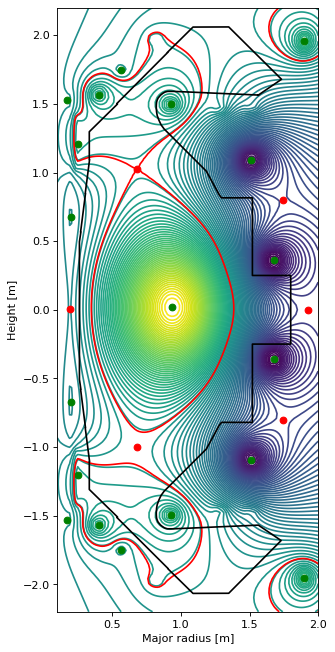

In [298]:
fig, ax = plt.subplots(figsize=(5, 10), dpi=80)
history_equilibria[-1].plot(axis=ax, show=False)

In [76]:
history_currents2 = np.array(history_currents)
history_times2 = np.array(history_times)
history_o_points2 = np.array(history_o_points)
history_width2 = np.array(history_width)
history_elongation2 = np.array(history_elongation)

Text(0, 0.5, 'Plasma elongation')

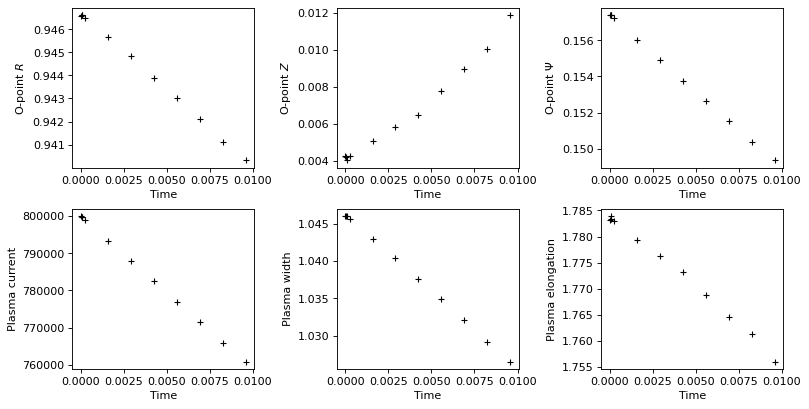

In [232]:
# Evolution of tracked values
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times, history_o_points[:, 0],'k+')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')

axs_flat[1].plot(history_times, history_o_points[:, 1],'k+')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('O-point $Z$')

axs_flat[2].plot(history_times, history_o_points[:, 2],'k+')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times, history_currents[:,-1],'k+')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times, history_width,'k+')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(history_times, history_elongation,'k+')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Plasma elongation')

Text(0, 0.5, 'Plasma elongation')

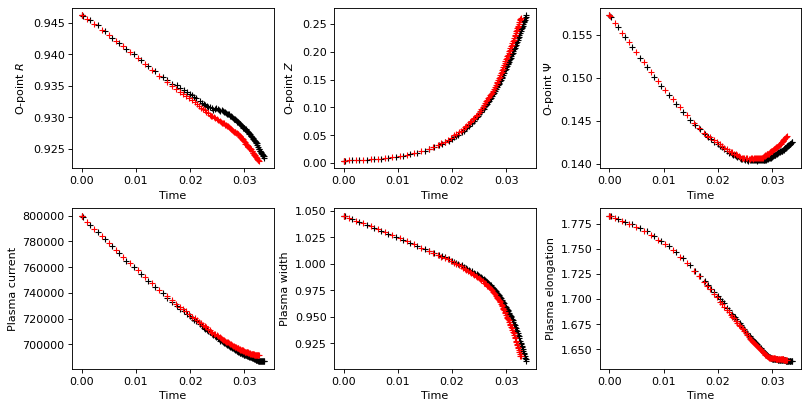

In [78]:
# Evolution of tracked values
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times1, history_o_points1[:, 0],'k+')
axs_flat[0].plot(history_times2, history_o_points2[:, 0],'r+')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')

axs_flat[1].plot(history_times1, history_o_points1[:, 1],'k+')
axs_flat[1].plot(history_times2, history_o_points2[:, 1],'r+')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('O-point $Z$')

axs_flat[2].plot(history_times1, history_o_points1[:, 2],'k+')
axs_flat[2].plot(history_times2, history_o_points2[:, 2],'r+')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times1, history_currents1[:,-1],'k+')
axs_flat[3].plot(history_times2, history_currents2[:,-1],'r+')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times1, history_width1,'k+')
axs_flat[4].plot(history_times2, history_width2,'r+')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(history_times1, history_elongation1,'k+')
axs_flat[5].plot(history_times2, history_elongation2,'r+')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Plasma elongation')

Text(0, 0.5, 'Plasma elongation')

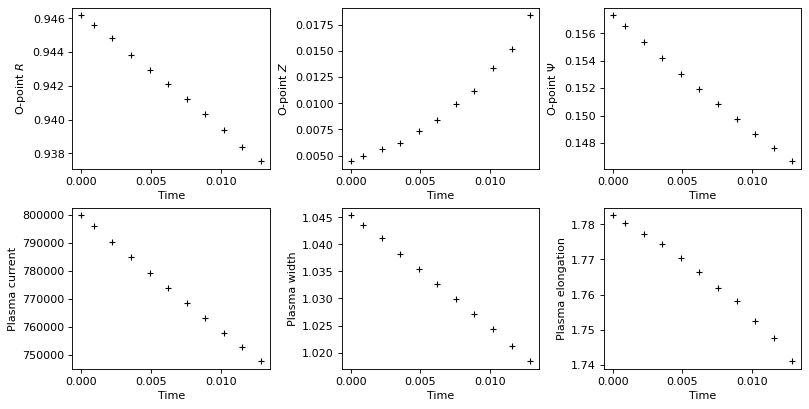

In [299]:
# Evolution of tracked values
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times, history_o_points[:, 0],'k+')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')

axs_flat[1].plot(history_times, history_o_points[:, 1],'k+')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('O-point $Z$')

axs_flat[2].plot(history_times, history_o_points[:, 2],'k+')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times, history_currents[:,-1],'k+')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times, history_width,'k+')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(history_times, history_elongation,'k+')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Plasma elongation')

/var/folders/n4/g0m7y66n7qj77q_n9txgrcmh0000gq/T/ipykernel_59774/725155918.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


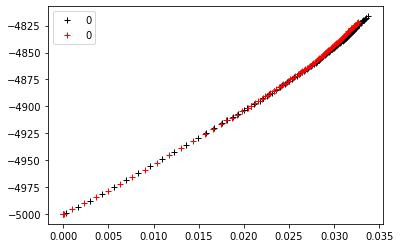

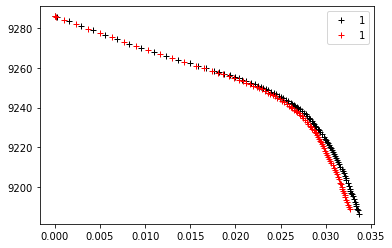

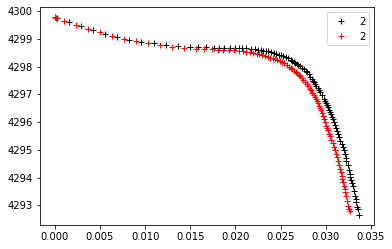

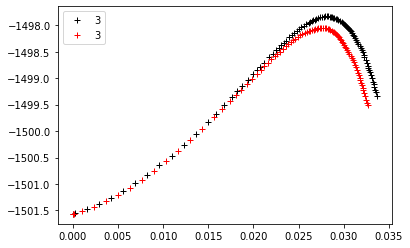

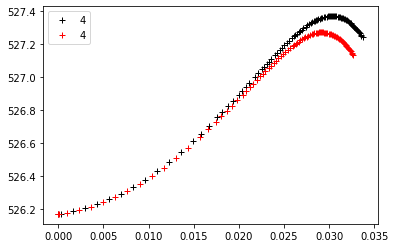

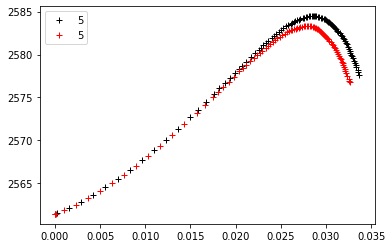

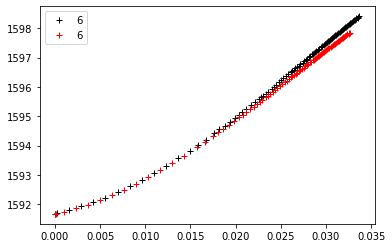

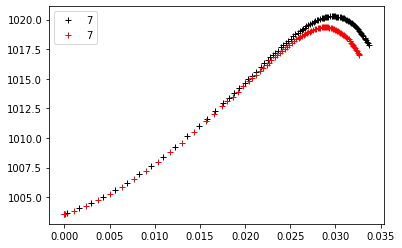

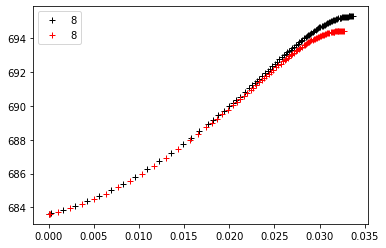

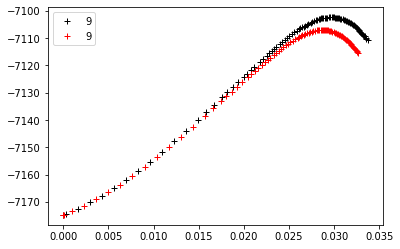

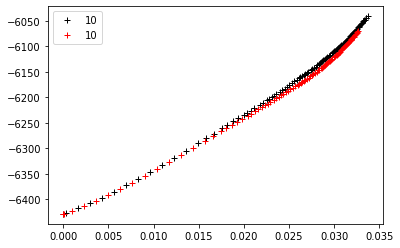

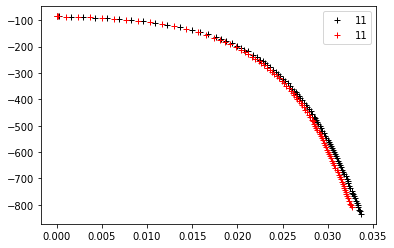

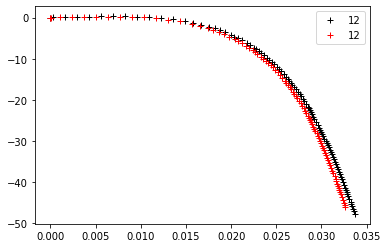

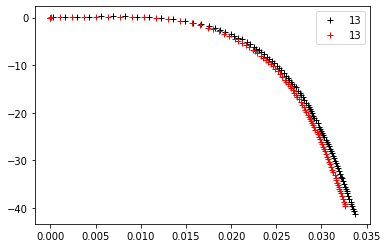

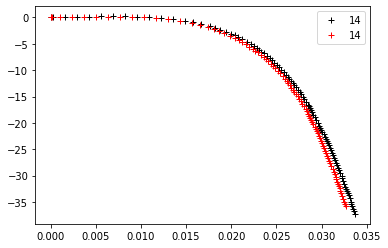

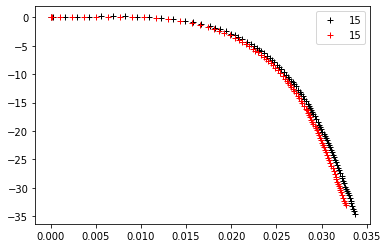

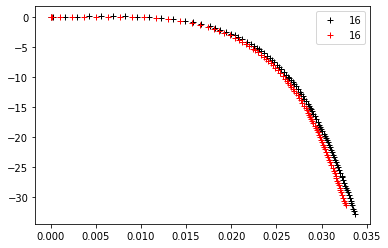

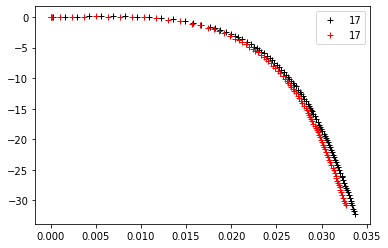

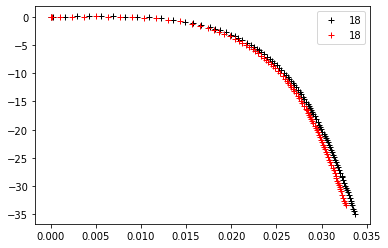

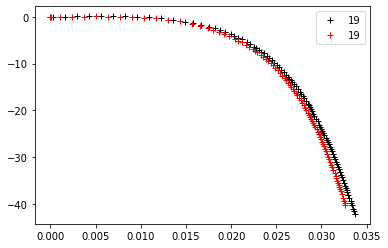

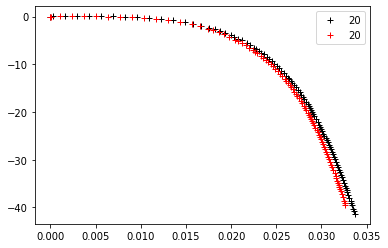

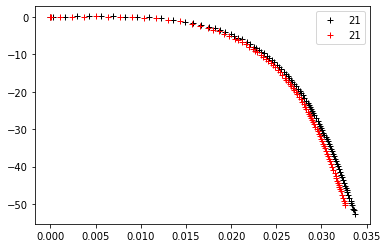

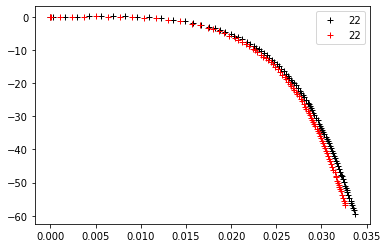

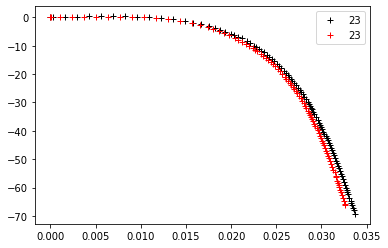

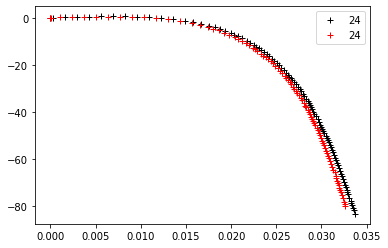

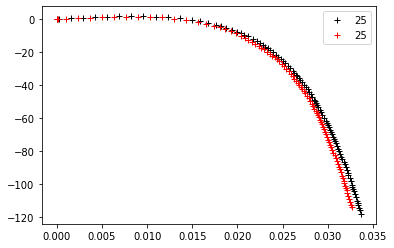

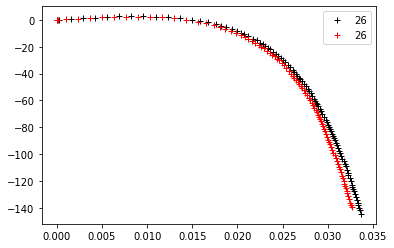

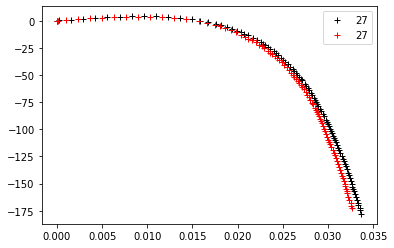

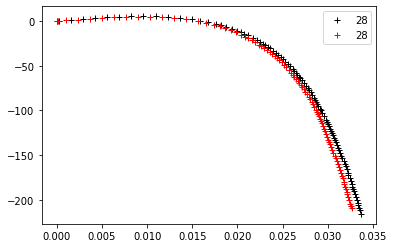

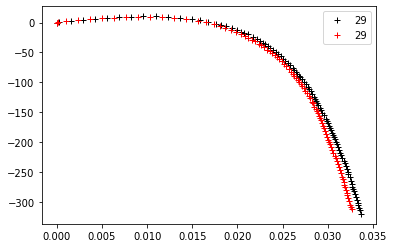

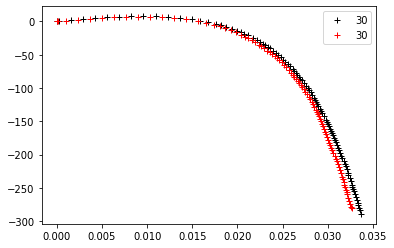

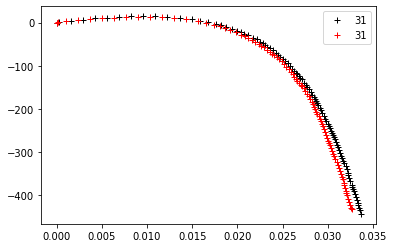

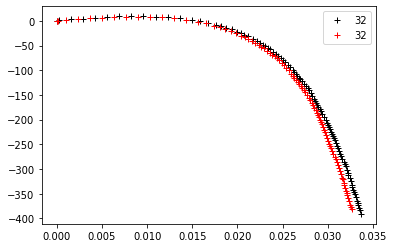

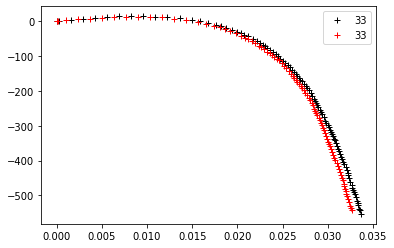

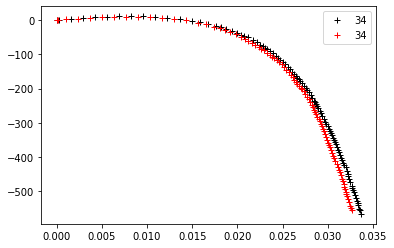

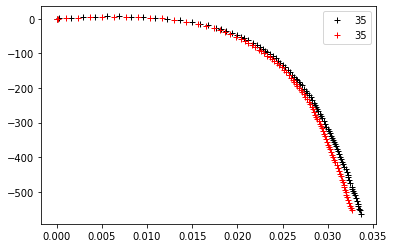

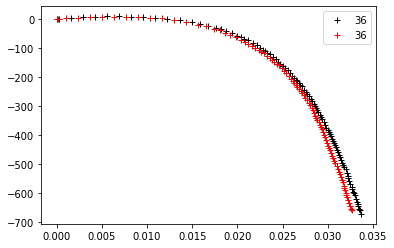

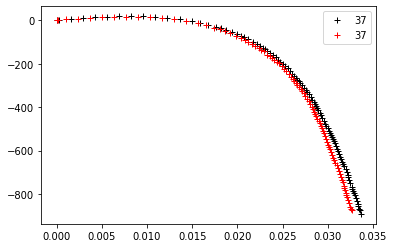

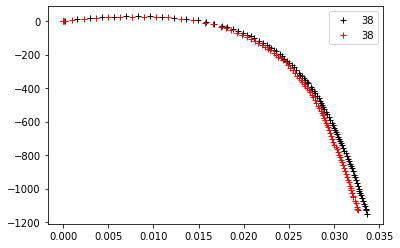

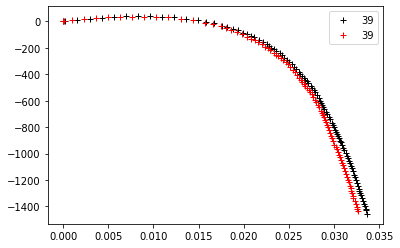

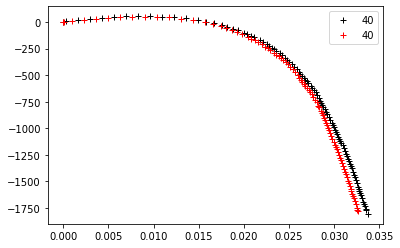

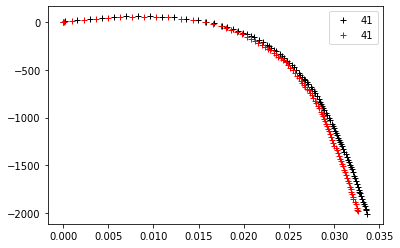

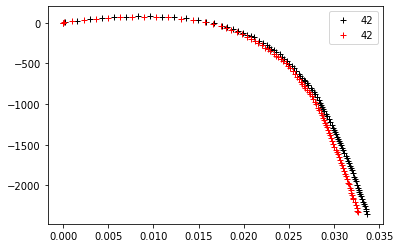

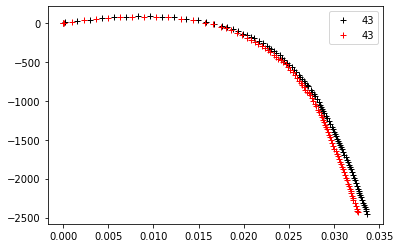

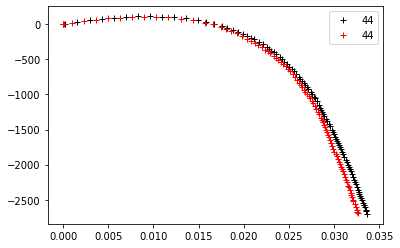

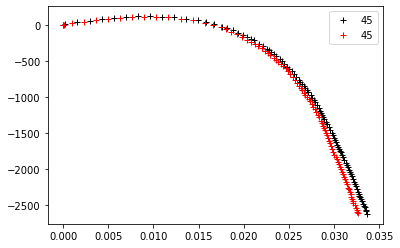

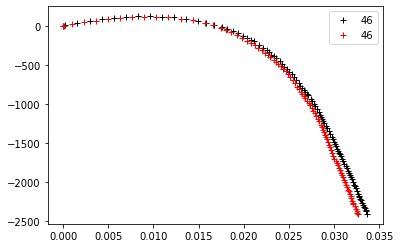

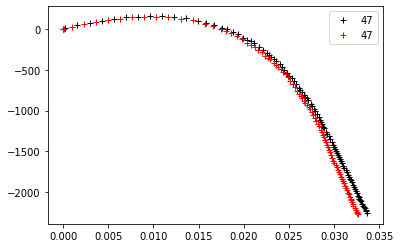

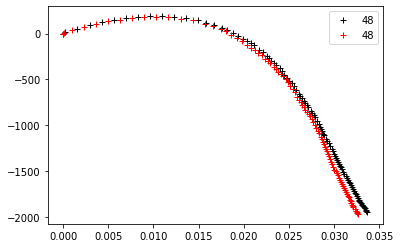

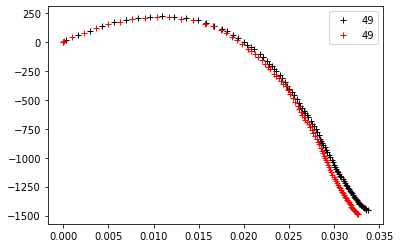

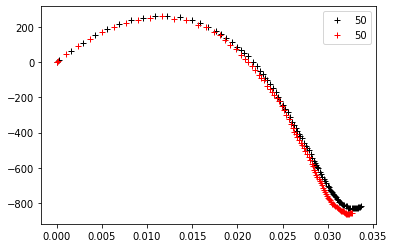

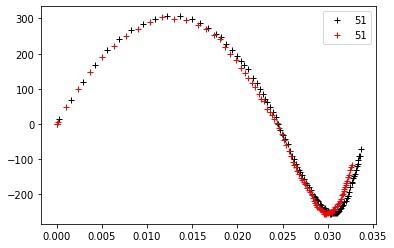

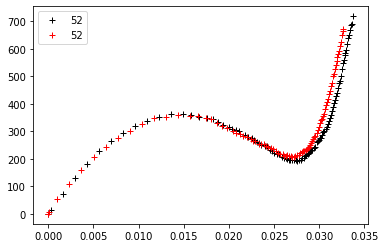

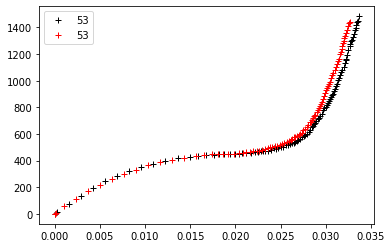

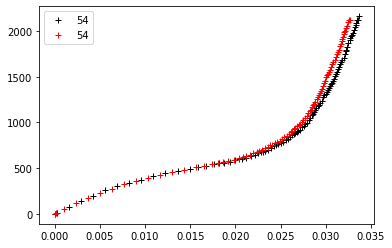

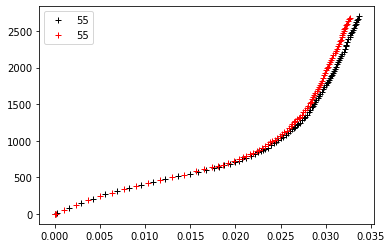

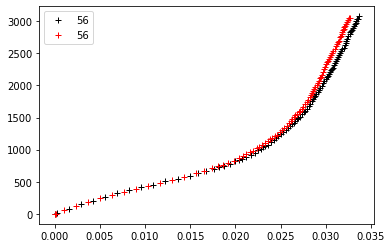

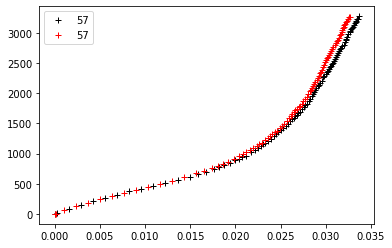

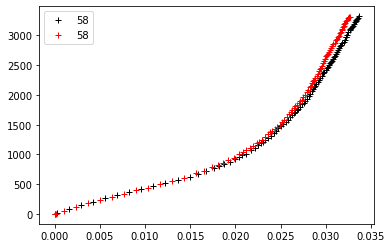

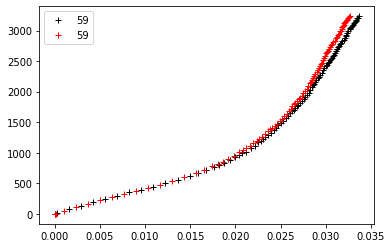

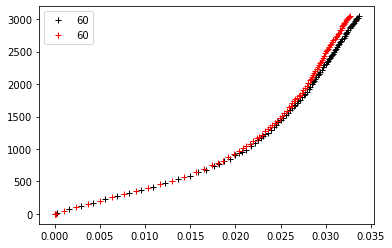

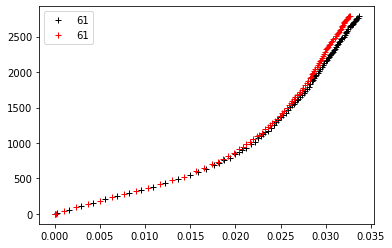

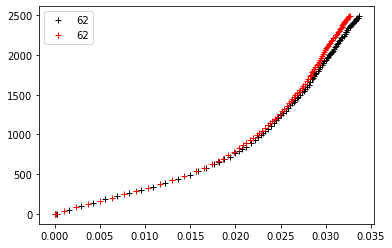

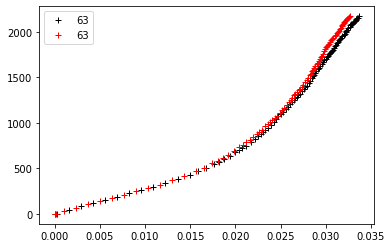

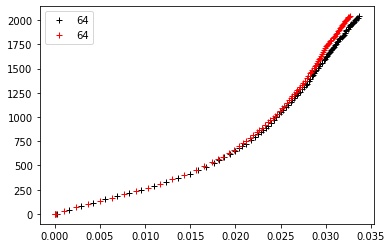

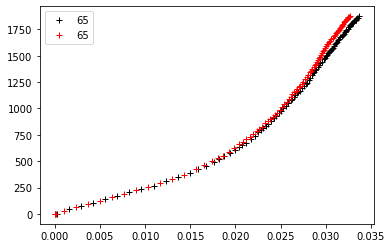

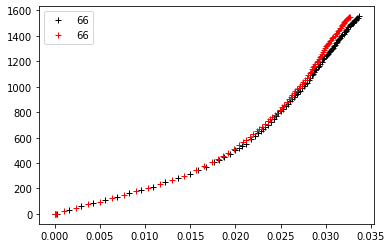

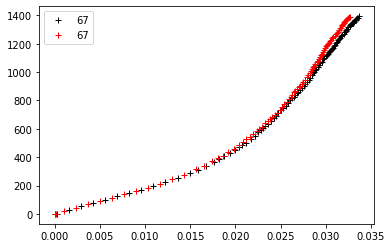

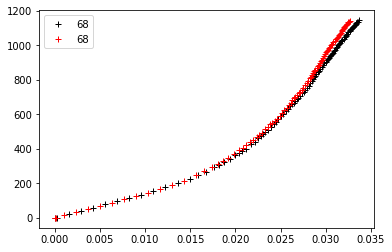

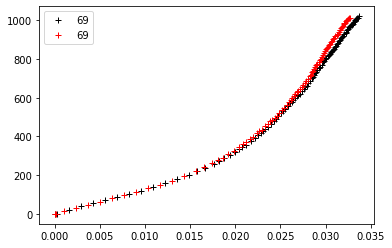

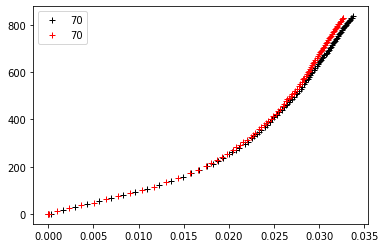

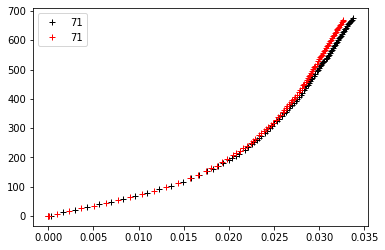

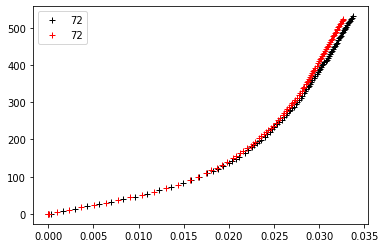

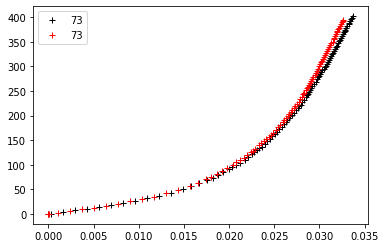

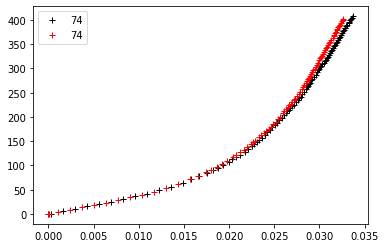

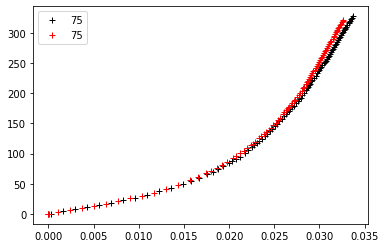

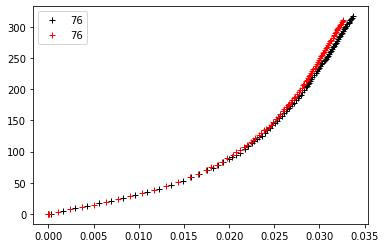

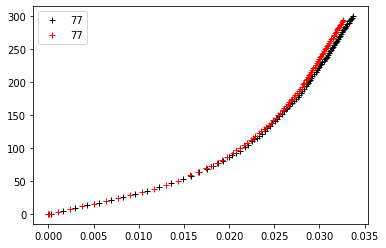

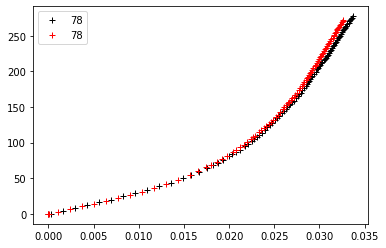

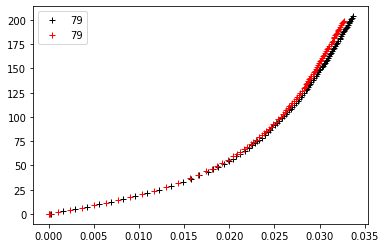

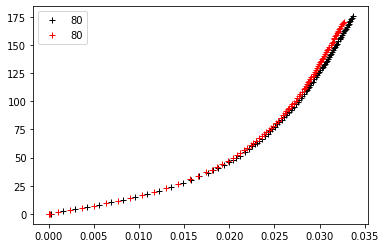

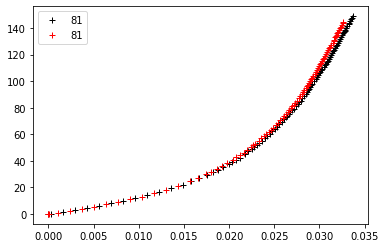

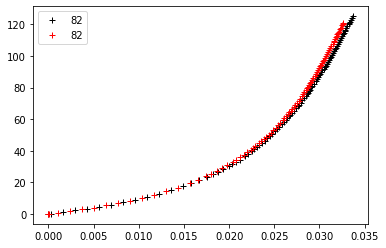

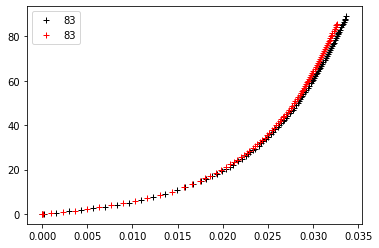

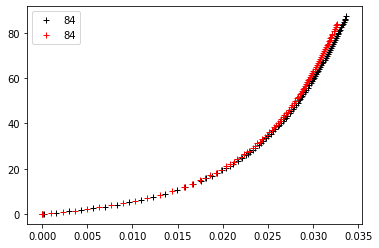

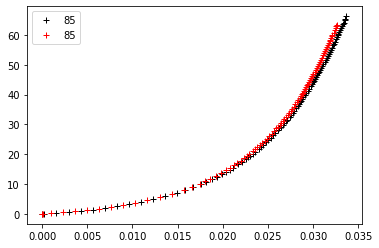

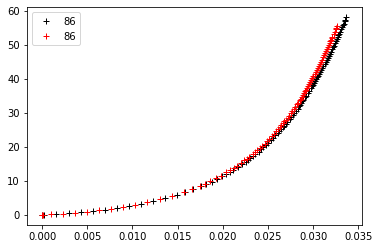

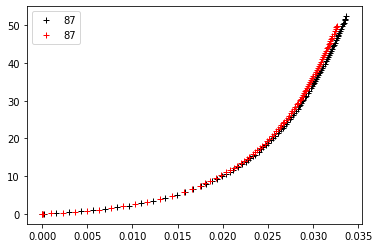

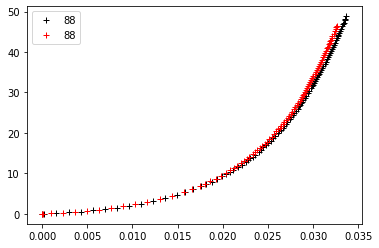

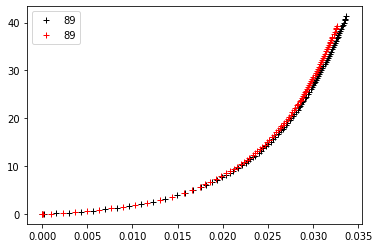

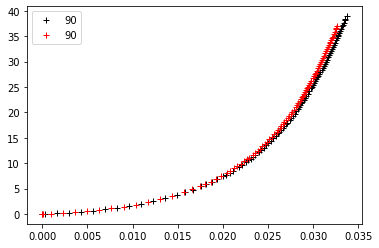

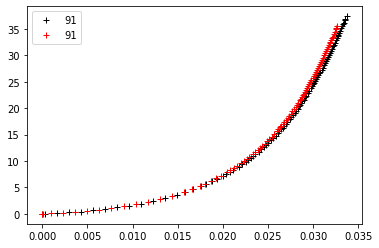

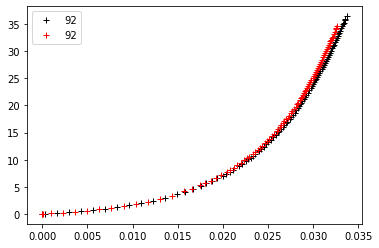

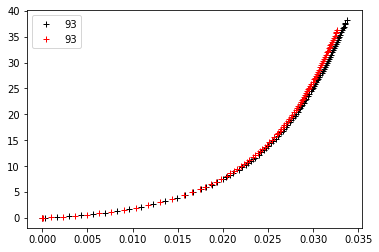

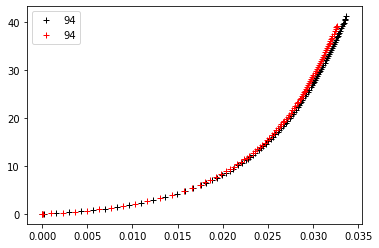

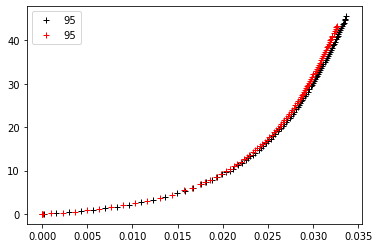

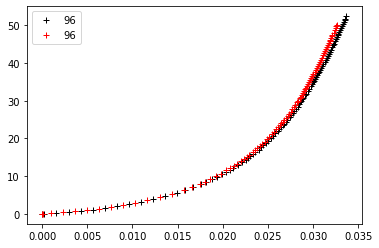

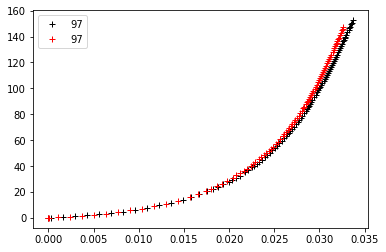

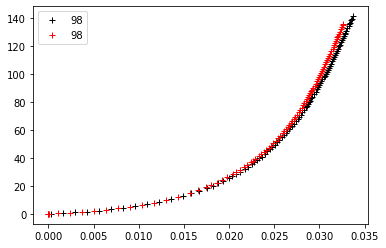

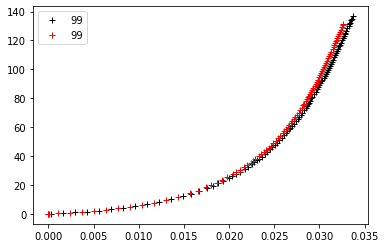

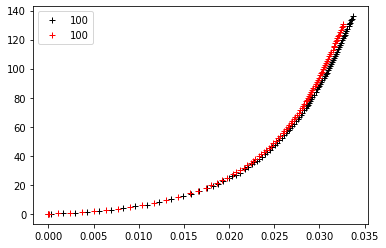

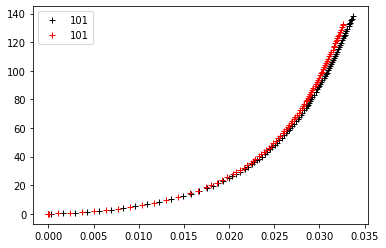

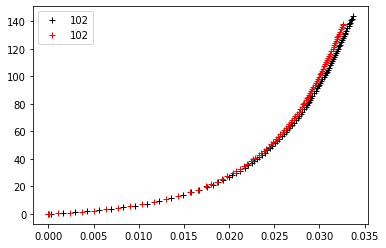

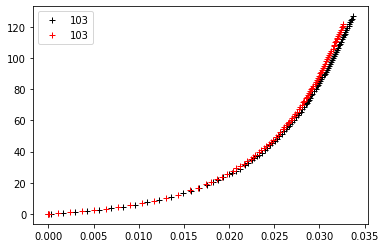

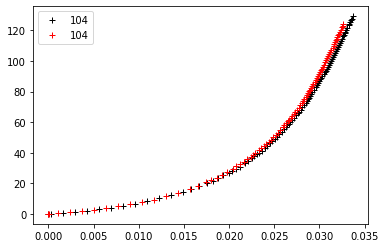

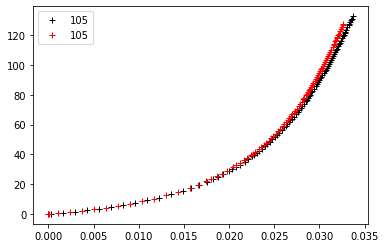

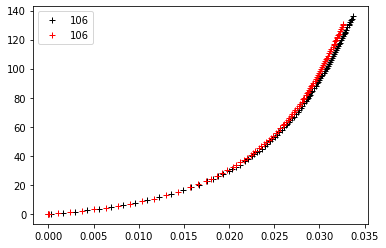

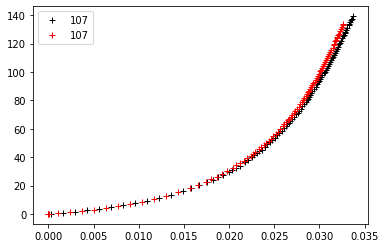

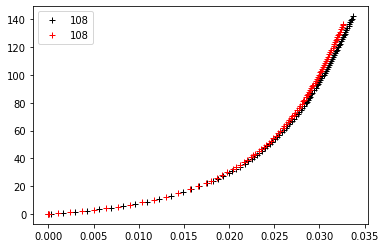

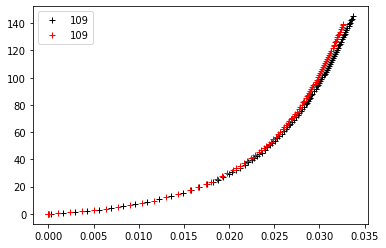

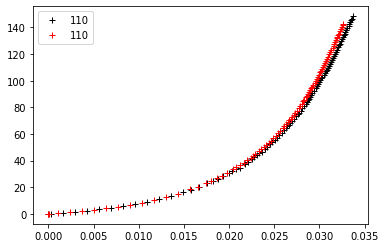

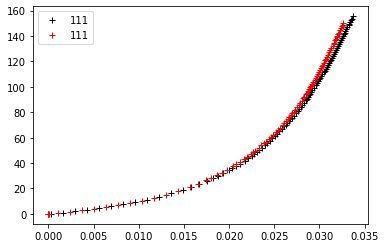

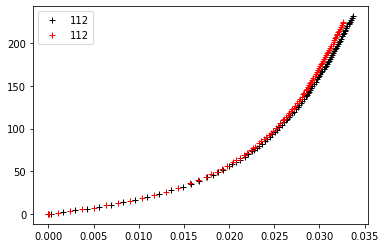

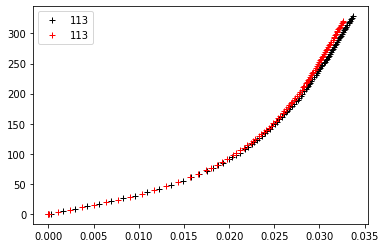

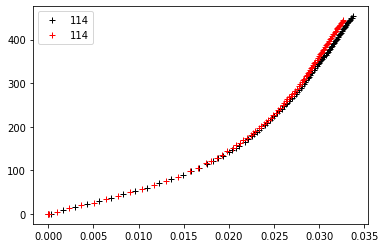

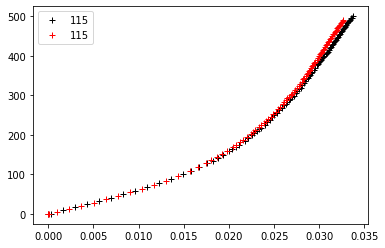

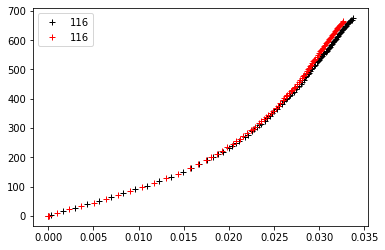

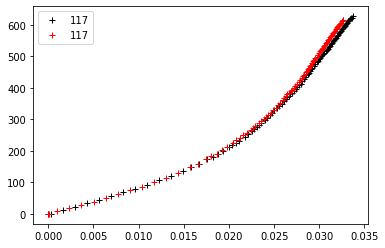

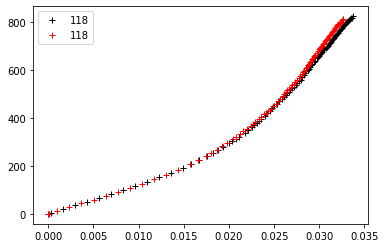

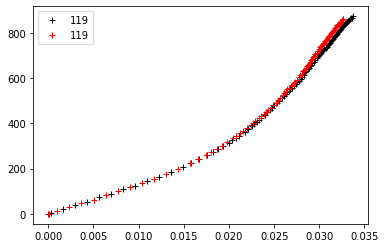

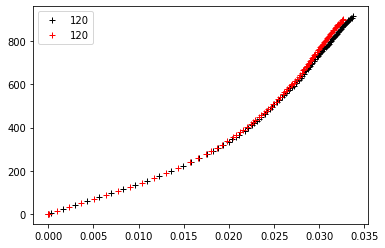

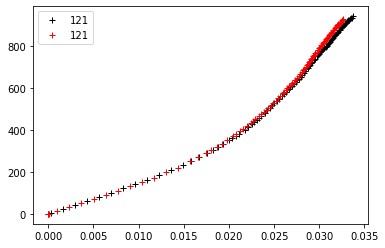

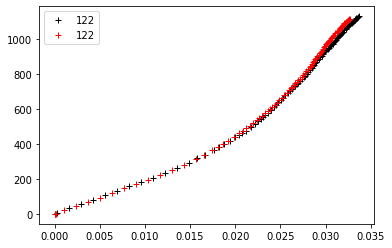

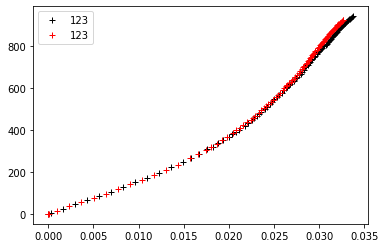

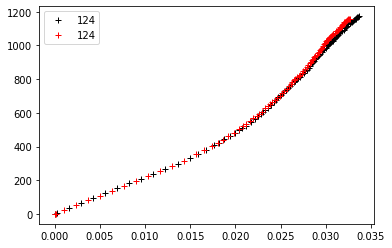

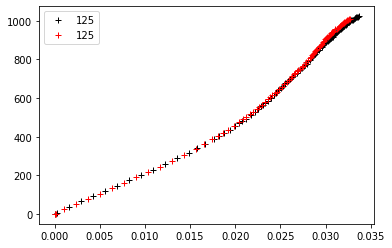

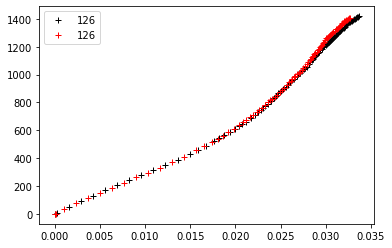

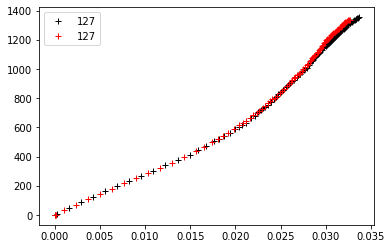

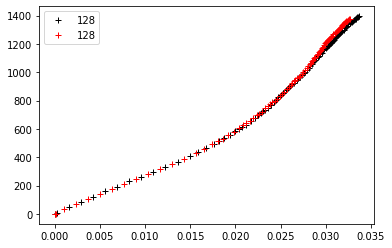

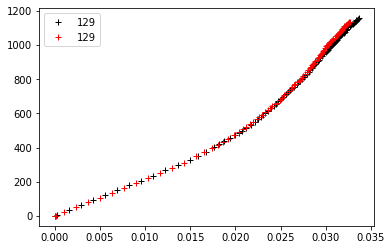

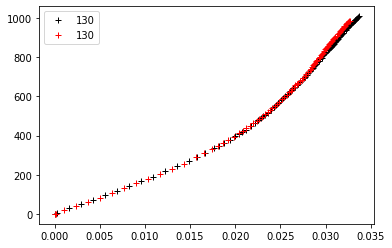

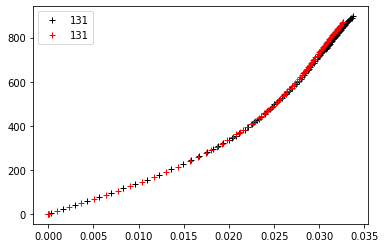

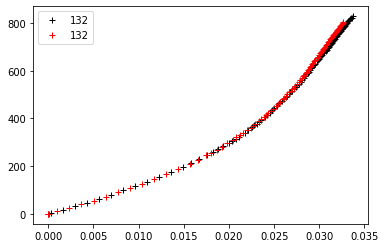

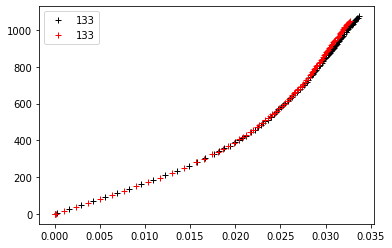

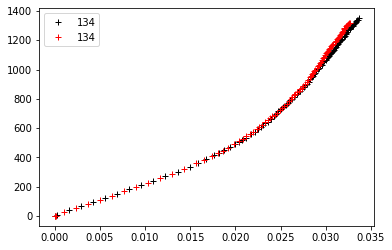

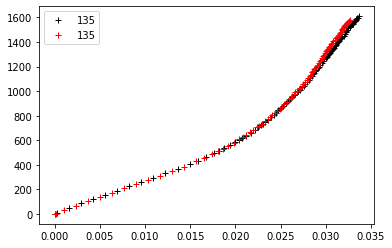

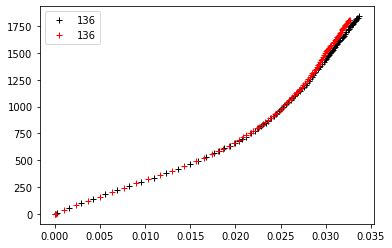

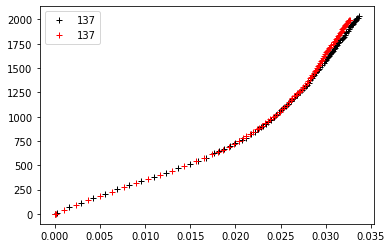

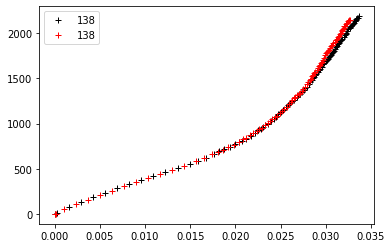

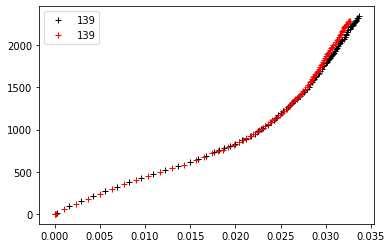

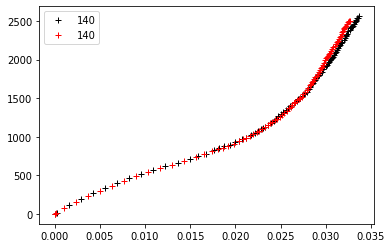

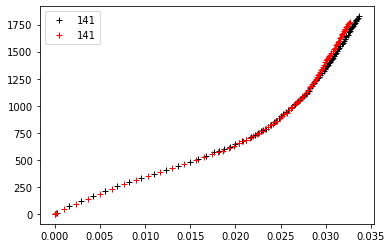

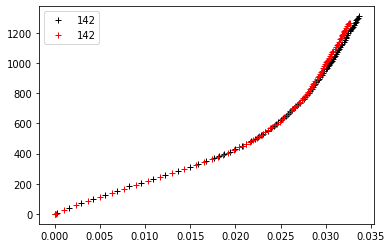

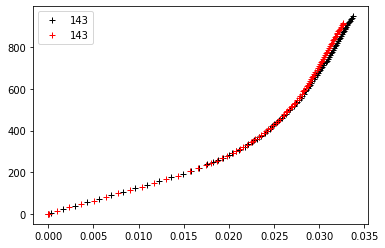

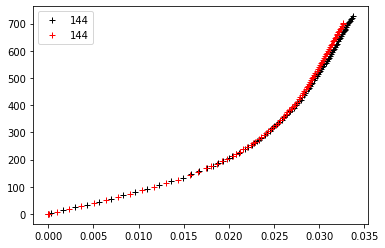

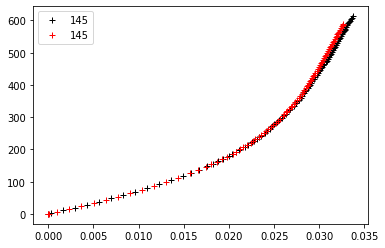

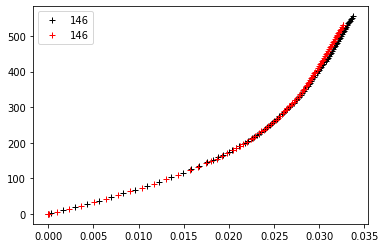

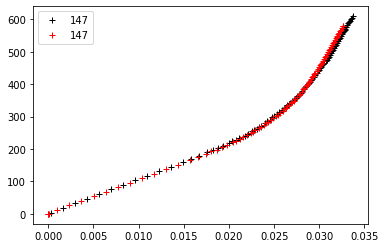

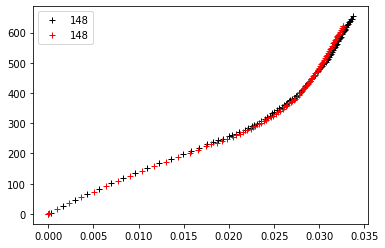

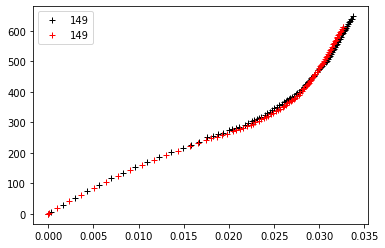

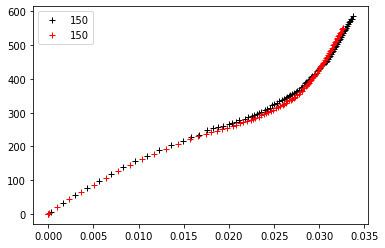

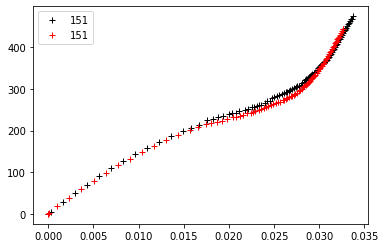

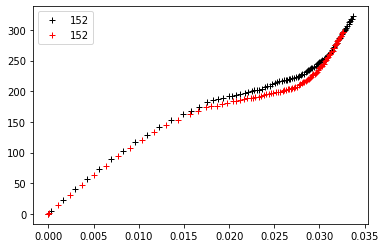

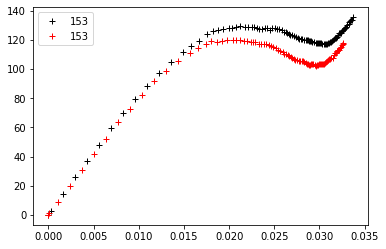

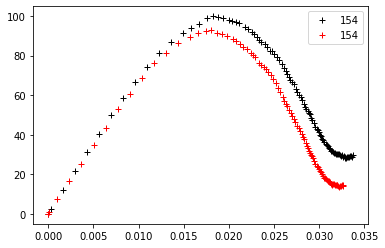

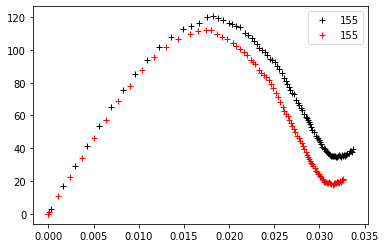

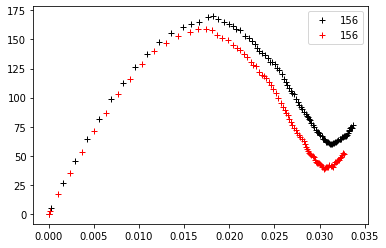

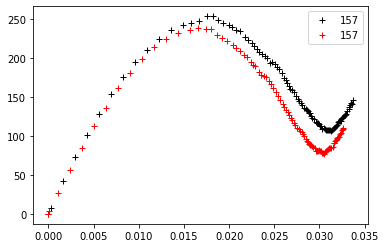

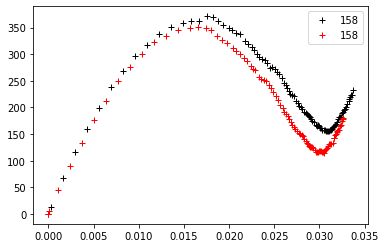

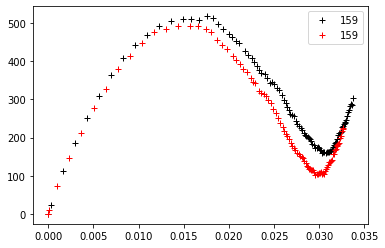

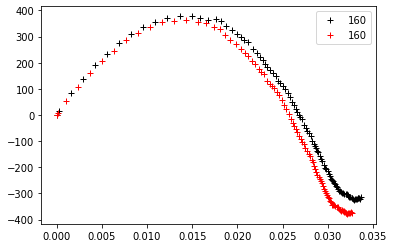

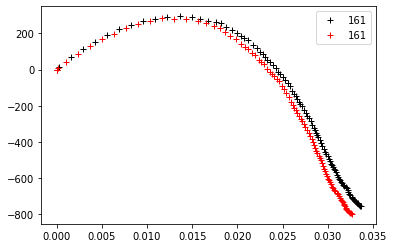

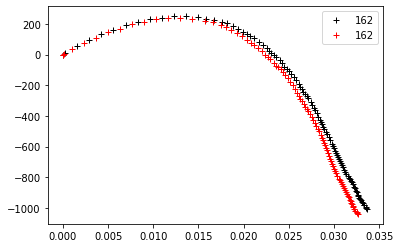

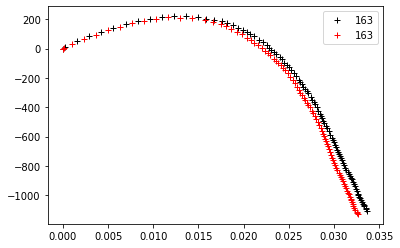

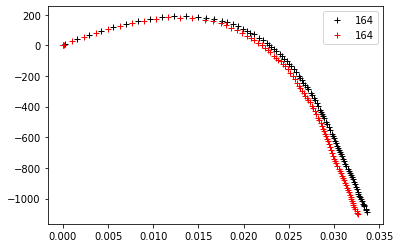

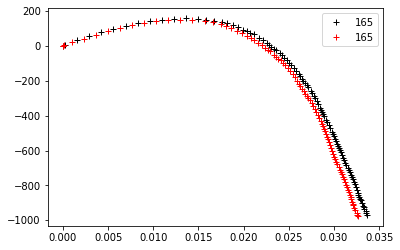

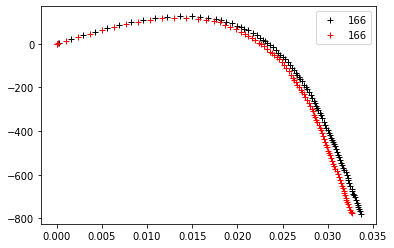

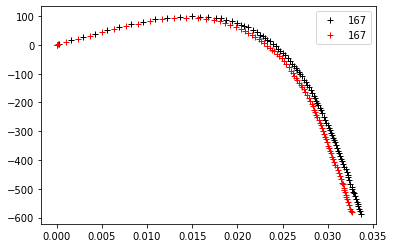

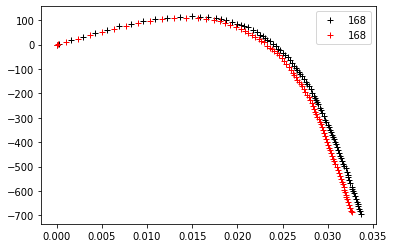

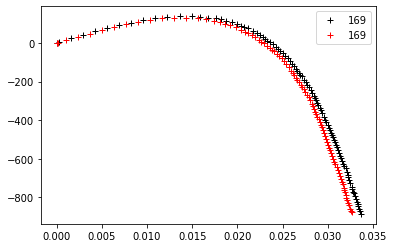

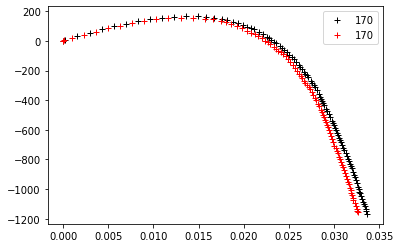

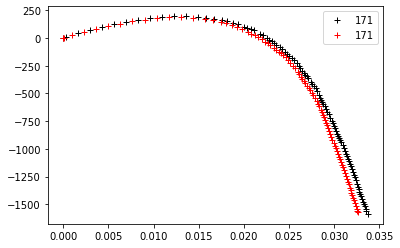

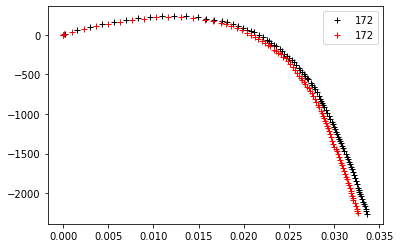

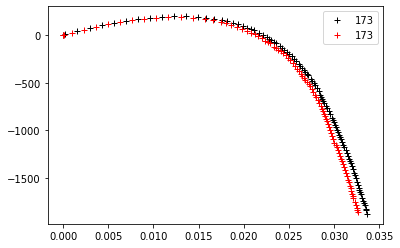

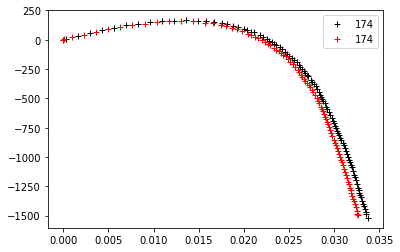

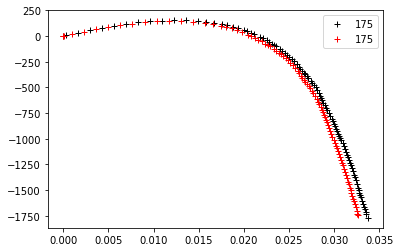

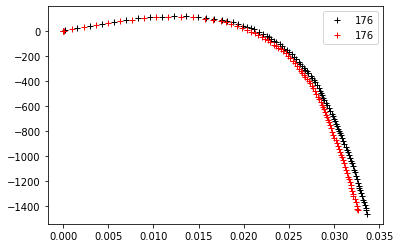

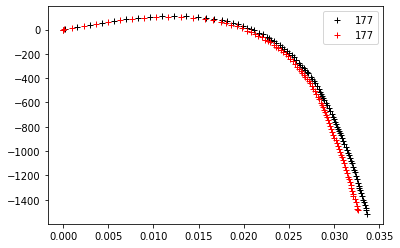

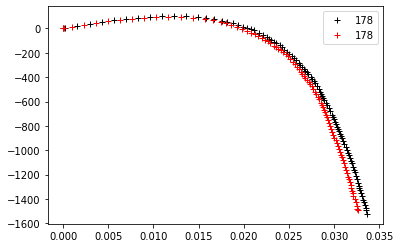

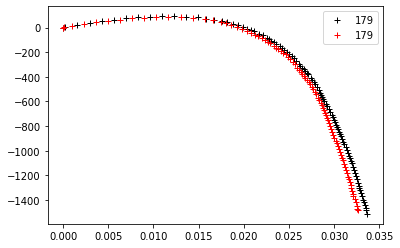

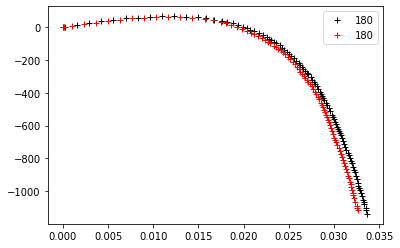

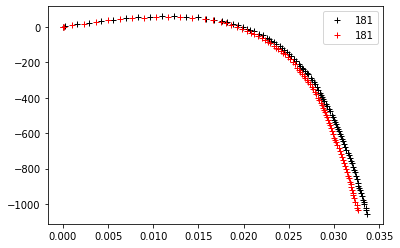

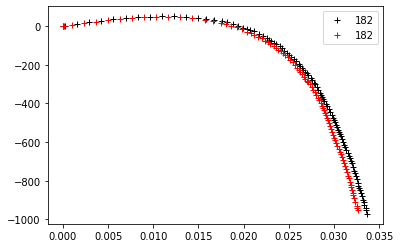

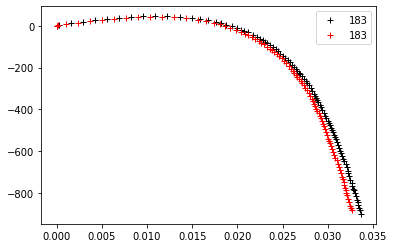

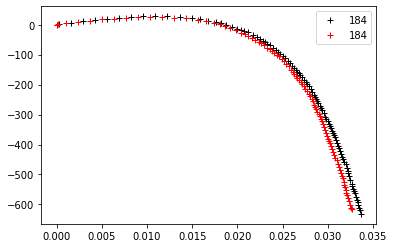

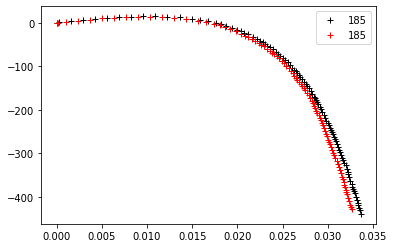

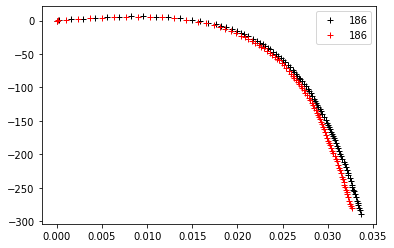

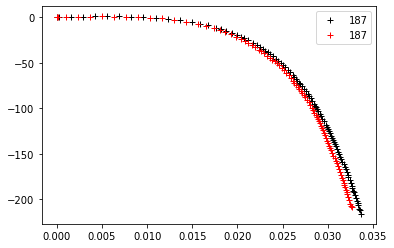

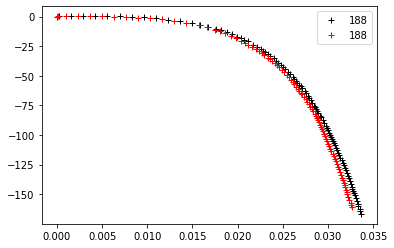

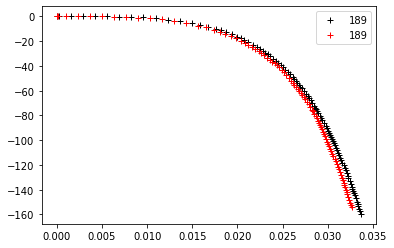

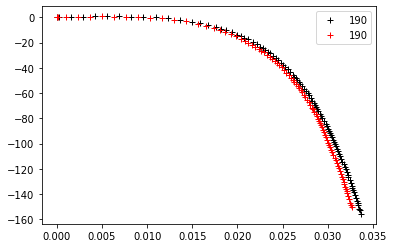

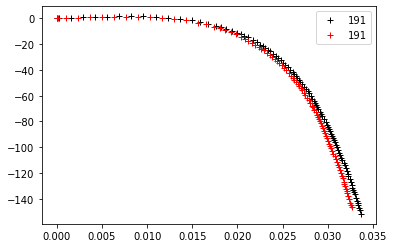

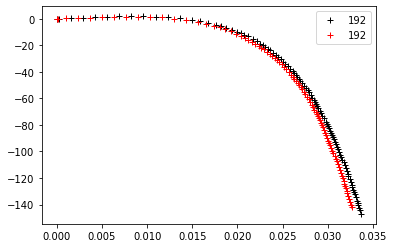

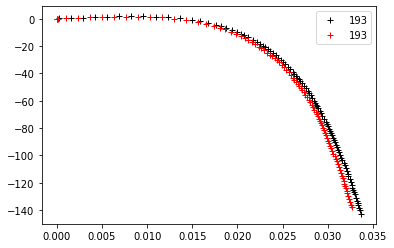

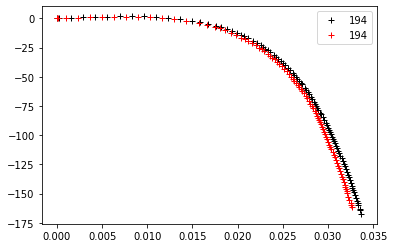

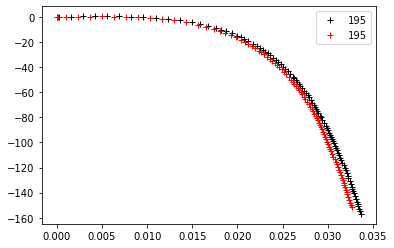

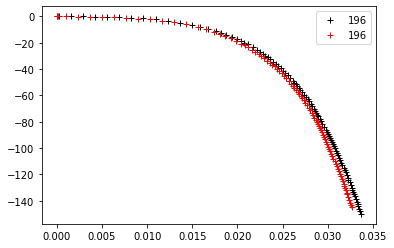

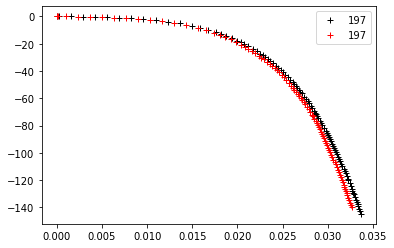

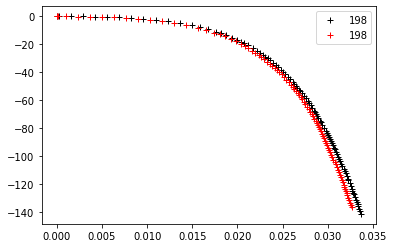

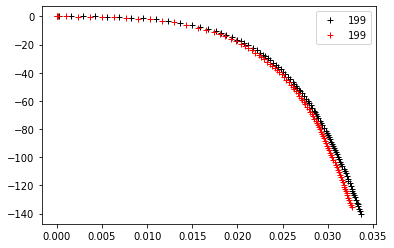

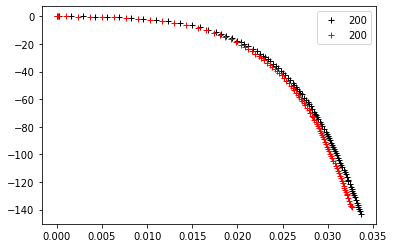

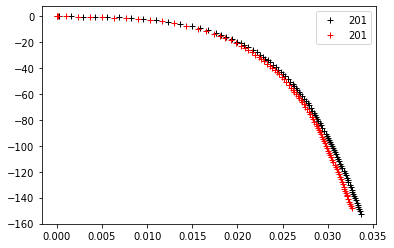

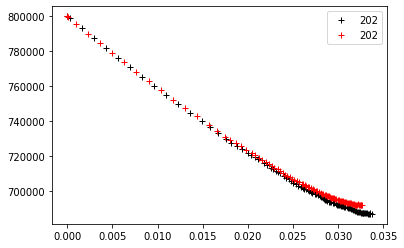

In [79]:
for i in range(len(stepping.currents_vec)):
    plt.figure()
    plt.plot(history_times1, history_currents1[:,i],'k+', label=str(i))
    plt.plot(history_times2, history_currents2[:,i],'r+', label=str(i))
    # plt.plot(history_times, history_currents[:,i],'g+', label=str(i))


    plt.legend()

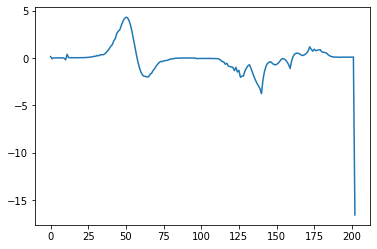

In [239]:
plt.plot(stepping.arnoldi_trials[-1,:-3])

In [236]:
stepping.arnoldi_trials[:,-3:]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 8.34458062e-03, 3.06560162e-04],
       [1.00000000e+00, 3.39734313e-02, 1.20913873e-04],
       [1.00000000e+00, 2.18955555e-02, 2.85680492e-04],
       [1.00000000e+00, 8.10671183e-03, 9.79223204e-05],
       [1.00000000e+00, 9.09507234e-01, 0.00000000e+00],
       [2.00000000e+00, 8.82016011e-01, 0.00000000e+00],
       [3.00000000e+00, 9.98818446e-03, 3.93997797e-03],
       [1.00000000e+00, 6.97880193e-02, 1.01757442e-03],
       [1.00000000e+00, 1.48024295e-01, 4.80986215e-04],
       [1.00000000e+00, 8.11291565e-01, 0.00000000e+00],
       [2.00000000e+00, 5.28564215e-02, 5.15445641e-04],
       [1.00000000e+00, 6.34236030e-01, 0.00000000e+00],
       [2.00000000e+00, 3.52630192e-02, 8.29010706e-05],
       [1.00000000e+00, 9.74834412e-02, 9.50717824e-04],
       [1.00000000e+00, 4.80426406e-01, 0.00000000e+00],
       [2.00000000e+00, 4.79463808e-02, 3.17459744e-04],
       [1.00000000e+00, 8.97996

In [14]:
1e-5*stepping.results1['plasma_ind_on_coils']/stepping.dt_step

array([4.58906393e-09, 3.35698247e-09, 5.02890480e-09, 8.02830920e-09,
       1.10879297e-08, 2.52771050e-08, 3.44951555e-08, 3.94213757e-08,
       4.56374142e-08, 6.65527966e-08, 1.26863518e-07, 4.54108808e-10,
       1.17713981e-08, 1.07740867e-08, 9.73632904e-09, 9.10364916e-09,
       7.96295259e-09, 7.16819176e-09, 5.96824651e-09, 5.85552380e-09,
       6.86694054e-09, 8.06521573e-09, 8.60990661e-09, 9.11308285e-09,
       1.06048971e-08, 1.09763422e-08, 1.11234515e-08, 1.24144251e-08,
       1.35551711e-08, 1.44261870e-08, 1.49217628e-08, 1.49761401e-08,
       1.45818528e-08, 1.37919045e-08, 1.27047393e-08, 1.14389802e-08,
       1.01082864e-08, 9.86404338e-09, 9.45509937e-09, 8.08776437e-09,
       7.62172864e-09, 7.13571397e-09, 6.08191021e-09, 5.19640954e-09,
       6.06421302e-09, 6.86107264e-09, 7.96154327e-09, 9.04940956e-09,
       9.64055339e-09, 1.06283120e-08, 3.45221546e-08, 3.19022018e-08,
       3.05245527e-08, 2.90980793e-08, 2.76276712e-08, 2.61189564e-08,
      

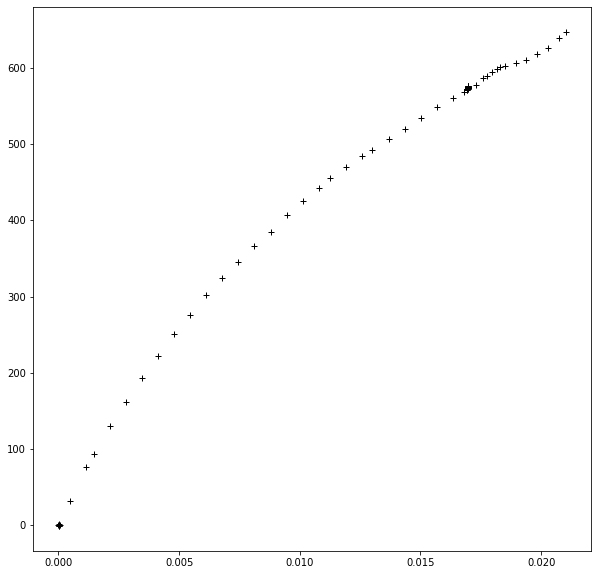

In [531]:
plt.figure(figsize=(10,10))
plt.plot(history_times, history_currents[:,32], 'k+')

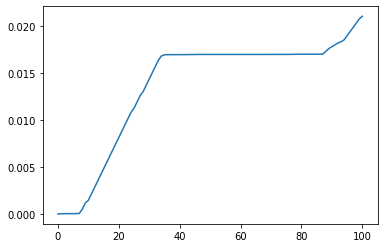

In [533]:
plt.plot(history_times)

In [34]:
eq.tokamak.getCurrents()

{'Solenoid': -4945.587582156683,
 'Px': 9266.78417623697,
 'D1': 4298.7695667226735,
 'D2': -1500.3771298564154,
 'D3': 526.4500720812653,
 'Dp': 2569.367300420126,
 'D5': 1593.160894352811,
 'D6': 1008.8010142380166,
 'D7': 686.4552316755172,
 'P4': -7150.006483212647,
 'P5': -6327.212936332911,
 'P6': -114.16073744067502,
 'pas_0': -0.13402889133362283,
 'pas_1': -0.10240900309214415,
 'pas_2': -0.09664540802053646,
 'pas_3': -0.10738634150029881,
 'pas_4': -0.13621644482902504,
 'pas_5': -0.19439105352658675,
 'pas_6': -0.2922889602880305,
 'pas_7': -0.3288967384694494,
 'pas_8': -0.46303177421824937,
 'pas_9': -0.4009039153423216,
 'pas_10': -0.37326259737782075,
 'pas_11': -0.27107740916694734,
 'pas_12': -0.0806127040997984,
 'pas_13': 1.0313252258003733,
 'pas_14': 2.042592950058718,
 'pas_15': 3.310284061509558,
 'pas_16': 4.592244559925268,
 'pas_17': 9.371731925918631,
 'pas_18': 6.432479004470926,
 'pas_19': 12.917324277566317,
 'pas_20': 7.302646289672665,
 'pas_21': 12.040

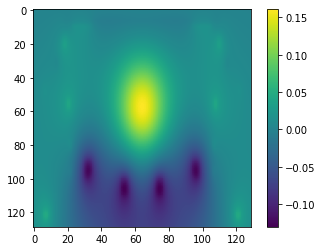

In [37]:
plt.imshow(eq.psi())
plt.colorbar()

In [43]:
psifull = eq.tokamak.calcPsiFromGreens(pgreen=eq._pgreen)

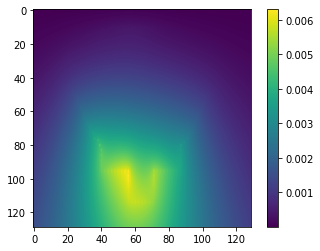

In [51]:
plt.imshow((psifull-eq.tokamak.calcPsiFromGreens(pgreen=eq._pgreen)))
plt.colorbar()

In [46]:
for i,labeli in enumerate(MASTU_coils.coils_dict.keys()):
    if labeli[:2] == 'pa':
        eq.tokamak[labeli].current = 0

In [53]:
np.max(psifull-eq.tokamak.calcPsiFromGreens(pgreen=eq._pgreen))-np.min(psifull-eq.tokamak.calcPsiFromGreens(pgreen=eq._pgreen))

0.0062980520925785145

In [56]:
0.0062980520925785145/(np.max(psifull)-np.min(psifull))

0.022196225172023593

In [234]:
stepping.NK.solve(eq, profiles, rel_convergence=1e-9, verbose=True, grad_eps=0.001, conv_crit=.3)

rel_change_0 0.006751500884106616
0.003898751310295517 coeffs= [-0.48957882  0.07035358 -0.00571729]
0.00165865514385268 coeffs= [-0.31623716 -0.30908709  0.26270742 -0.17039244]
0.000509548767254486 coeffs= [-0.0496254  -0.14110315  0.21258147 -0.02020209]
5.167269113228727e-05 coeffs= [-0.24992386  1.08526353  1.61052565 -0.59178623  0.16351465]
1.084450780558062e-05 coeffs= [-0.15451364 -0.06708908  0.06998973]
2.499488542237126e-06 coeffs= [ 0.68719922 -1.04330518  0.24919213]
3.9359613510162673e-07 coeffs= [-0.5142536   0.78435221 -0.15019232]
1.0480241831580044e-07 coeffs= [-0.19442402  0.25174066  0.00454337 -0.04714792]
1.721057650352668e-08 coeffs= [ 0.42430698 -0.20050843  1.46694773 -0.46103912  0.16938065]
4.198752802500556e-09 coeffs= [-0.03845898 -0.20209912  0.19846934 -0.45790425  0.15058112]
3.5501574326091806e-10 coeffs= [-0.09001195 -0.14949836  0.16486866 -0.19685034  0.06860368]


In [233]:
profiles = freegs.jtor.ConstrainPaxisIp(2e3, # Plasma pressure on axis [Pascals]
                                        8e5, # Plasma current [Amps]
                                        0.5, # vacuum f = R*Bt
                                        alpha_m = 1.0,
                                        alpha_n = 2.0)

In [168]:
np.linalg.norm(stepping.NK._F(eq.plasma_psi))

0.003106469465742573